# Compatibility of wind turbines with RAS

## License

```
Wind turbine compatibility with RAS observations.
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

## Studying reflections of 3rd-party services by wind turbines
The third and final notebook about compatibility considerations between RAS and wind turbines is about the (probably rarer) case of reflections. A 3rd-party service might operate in the same area and a wind turbine (WT), being relatively high, may produce reflections that might disturb RAS observations. Naively, the reflected signal is expected to be much weaker at the radio telescope (RT) than the unwanted emission form the 3rd-party transmitter directly. Still, it would be good to do a sanity check and doing the calculations might also give some insights, how pycraf can be utilized for such analyses.

In the notebook about [Fixed service links](A01_case_study_fixed_link.ipynb) we already looked at how much unwanted emission from a fixed-link (FL) transmitter would make it to the RAS receiver. Here, we put a wind turbine close to the FL and calculate how much is reflected.

### RADAR
For such a scenario, the RADAR equation seems an appropriate tool, which returns the strength of a RADAR pulse that is first transmitted, then reflected off some target, and eventually received by the RADAR receiver. The detected RADAR pulse is weaker than the emitted pulse by a ratio that goes with distance to the 4th power. However, in our case, the receiver and transmitter are not at the same location, so the detected signal is proportional to $d_\mathrm{fl,wt}^2 d_\mathrm{wt,rt}^2$. The RADAR equation

$$
P_\mathrm{rt} = \frac{G_\mathrm{fl} P_\mathrm{fl}}{4\pi d_\mathrm{fl,wt}^2} \sigma \frac{A_\mathrm{eff}}{4\pi d_\mathrm{wt,rt}^2}
$$

gives us the following recipe:

- Calculate power flux density at WT from FL emission; depends on $d_\mathrm{fl,wt}^2$. For accurate results calculate full path attenuation and account for FL antenna pattern.
- Determine re-emitted power, which is simply this power flux density multiplied with RADAR cross-section, $\sigma$.
- Do path propagation loss calculations to determine received power at RT. The effective area of the RT, $A_\mathrm{eff}$, is very small if we again consider the 0-dBi case.

Note, the RADAR cross section depends on the target's area, and its surface directivity and reflectivity. For simplicity, we will assume that the WT's surface directivity is isotropic (i.e., the incident wave is reflected equally into all directions). This is certainly not quite true, but we are not aware of measurements of real WT cross sections. For the reflectivity, we think that 90% for the base (made of steel and concrete) and 10% for the rotor (composite material) could be realistic. 

These calculations are straight forward. However, the path loss depends on the heights of the reflecting surface. Therefore, our strategy will be to split the WT into height bins and do the calculation for each little patch individually.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point, MultiPoint
from astropy import units as u
from pycraf import antenna, pathprof, geometry, conversions as cnv

### Preparations
Before we can start, we need to know the geometric area of the wind turbines (separatly for base and rotor) as a function of height. In the following, all quantities are binned by height, with a bin width of 1-m. To obtain the area height profile, we will parametrize the WT by small quadratic patches. Of course, one could work this out analytically as well, but the following approach would be easier to apply to more complicated reflective surfaces.

In [3]:
# define wind turbine (100 m) as polygon, can be scaled, if necesary

d_base, d_gen, h_base = 8, 4, 160

_wbase_poly = np.array([
    (0, 0), (d_base / 2, 0), (d_gen / 2, h_base),
    (-d_gen / 2, h_base), (-d_base / 2, 0), (0, 0)
    ])

alpha = 0  # w.r.t. zenith
r_rot, base_rot = 80, 5
_u = base_rot / 2
_v = _u / np.sqrt(3)
_w = _v + r_rot

sa, ca = np.sin(np.radians(alpha)), np.cos(np.radians(alpha))
s120, c120 = np.sin(np.radians(-120)), np.cos(np.radians(-120))
s240, c240 = np.sin(np.radians(-240)), np.cos(np.radians(-240))

_wrot_poly0 = np.array([
    (0, _w),
    (-_u, _w),
    (-1.5 * _u, 1.5 * _v),
    (_w * s120, _w * c120),
    (-_u * c120 + _w * s120, _u * s120 + _w * c120),
    (-1.5 * _u * c120 + 2 * _v * s120, 1.5 * _u * s120 + 2 * _v * c120),
    (_w * s240, _w * c240),
    (-_u * c240 + _w * s240, _u * s240 + _w * c240),
    (-1.5 * _u * c240 + 2 * _v * s240, 1.5 * _u * s240 + 2 * _v * c240),
    (0, _w)
    ])
_wrot_poly = np.array([
    (t[0] * ca + t[1] * sa, -t[0] * sa + t[1] * ca + h_base)
    for t in _wrot_poly0
    ])


wbase_poly = Polygon(_wbase_poly)
wrot_poly = Polygon(_wrot_poly)


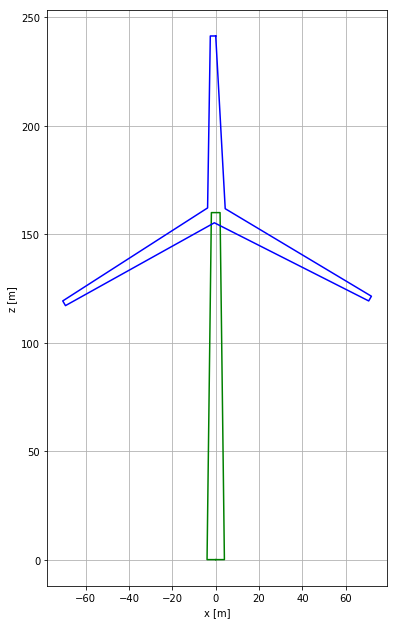

In [4]:
plt.close()
fig = plt.figure(figsize=(8, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
ax.plot(_wbase_poly[:, 0], _wbase_poly[:, 1], 'g-')
ax.plot(_wrot_poly[:, 0], _wrot_poly[:, 1], 'b-')
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect(1.)
ax.grid()
plt.show()

In [5]:
def make_points(poly, grid_spacing):
    grid = grid_spacing
    bounds = poly.bounds
    w_x, w_z = np.meshgrid(
        np.arange(bounds[0], bounds[2] + grid / 2, grid),
        np.arange(bounds[1], bounds[3] + grid / 2, grid),
        )
    w_y = w_x * 0.
    points = np.fromiter(
        zip(w_x.flatten(), w_y.flatten(), w_z.flatten()),
        dtype=np.dtype([('x', 'f8'), ('y', 'f8'), ('z', 'f8')])
        )
    mask = np.array([
        poly.contains(Point(x, z)) for (x, y, z) in points
        ], dtype=np.bool)
    return points[mask]

In [6]:
# sample with 1-m grid
GRID_SPACING = 1
wbase_points = make_points(wbase_poly, GRID_SPACING)
wrot_points = make_points(wrot_poly, GRID_SPACING)

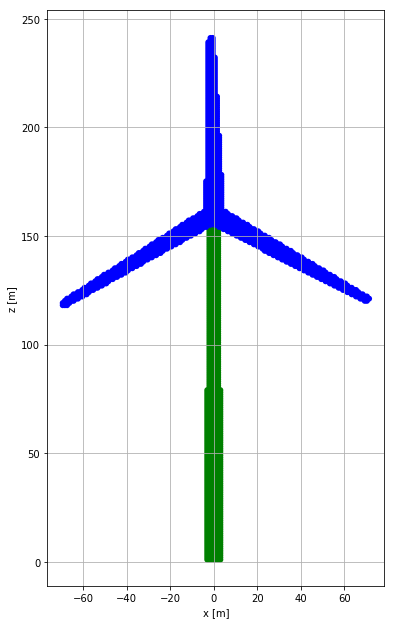

In [7]:
plt.close()
fig = plt.figure(figsize=(8, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
ax.scatter(wbase_points['x'], wbase_points['z'], c='g', edgecolor='none')
ax.scatter(wrot_points['x'], wrot_points['z'], c='b', edgecolor='none')
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_aspect(1.)
ax.grid()
plt.show()

This may be a bit coarse for calculating the area height profile. Let's increase the resolution.

In [8]:
def wt_area_profile(points, hminmax=None):
    if hminmax is None:
        hmin, hmax = points['z'].min(), points['z'].max()
    else:
        hmin, hmax = hminmax
    height_bins = np.arange(np.floor(hmin), np.ceil(hmax), 1)
    height_mids = height_bins[:-1] + np.diff(height_bins) / 2

    hist, _ = np.histogram(points['z'], height_bins)
    bin_area = hist * GRID_SPACING ** 2
    
    return height_mids, bin_area

The following is rather slow, but we have to do it only once, so it's ok.

In [9]:
# height-bin windmill
GRID_SPACING = 0.1
wbase_points = make_points(wbase_poly, GRID_SPACING)
wrot_points = make_points(wrot_poly, GRID_SPACING)

In [10]:
all_heights = np.hstack([wbase_points['z'], wrot_points['z']])
hmin, hmax = np.floor(all_heights.min()) - 1, np.ceil(all_heights.max()) + 1

wbase_hmids, wbase_binarea = wt_area_profile(wbase_points, (hmin, hmax))
wrot_hmids, wrot_binarea = wt_area_profile(wrot_points, (hmin, hmax))

Later, we'll only need the effective area per height bin (i.e., after applying RADAR cross section).

In [11]:
eta_wbase, eta_wrot = 0.9, 0.1
cross_section = eta_wbase * wbase_binarea + eta_wrot * wrot_binarea
hmids = wbase_hmids

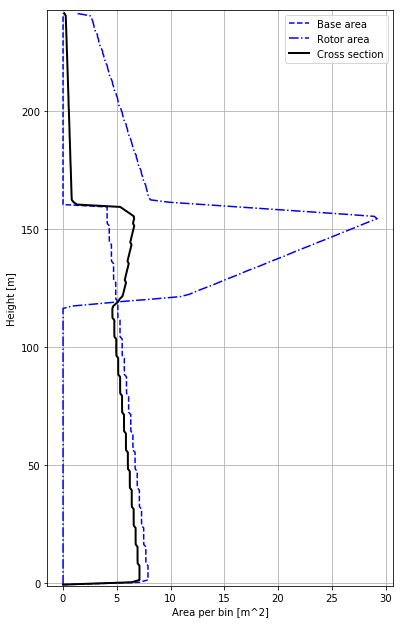

In [12]:
fig = plt.figure(figsize=(6, 10))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
ax.plot(wbase_binarea, wbase_hmids, 'b--', label='Base area')
ax.plot(wrot_binarea, wrot_hmids, 'b-.', label='Rotor area')
ax.plot(cross_section, hmids, 'k', lw=2, label='Cross section')
ax.legend(*ax.get_legend_handles_labels())
ax.set_ylim((hmin, hmax))
ax.set_xlabel('Area per bin [m^2]')
ax.set_ylabel('Height [m]')
ax.grid()

Setting up some coordinates. Because we suspect, that the reflected power will be much lower than from the direct path, we'll put the WT really close to the FL transmitter. It should be noted, though, that the WT is then in the near-field of the FL Tx, such that P.452 doesn't apply anymore.

In [13]:
# set-up coordinates
lon_rt, lat_rt = 6.8836 * u.deg, 50.525 * u.deg  # 100-m Effelsberg radio telescope
lon_fl_tx, lat_fl_tx = 6.938 * u.deg, 50.494 * u.deg
lon_fl_rx, lat_fl_rx = 6.925 * u.deg, 50.528 * u.deg
lon_wt, lat_wt = 6.9385 * u.deg, 50.496 * u.deg
hprof_step = 10 * u.m

Plotting this, to get an idea of the environment:

In [14]:
map_size_lon, map_size_lat = 0.25 * u.deg, 0.25 * u.deg
map_resolution = 3. * u.arcsec

lons, lats, heightmap = pathprof.srtm_height_map(
    lon_rt, lat_rt,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    )

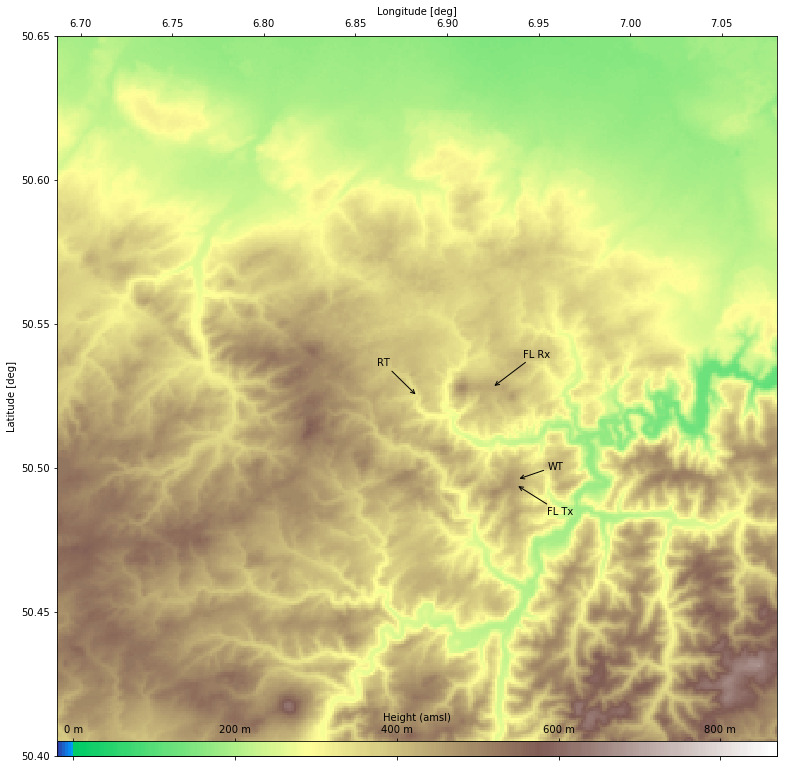

In [15]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value
_heightmap = heightmap.to(u.m).value

vmin, vmax = -20, 870
terrain_cmap, terrain_norm = pathprof.terrain_cmap_factory(sealevel=0.5, vmax=vmax)

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _heightmap,
    origin='lower', interpolation='nearest',
    cmap=terrain_cmap, norm=terrain_norm,
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Height (amsl)', color='k')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 1150, 200)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.annotate(
    'RT', xy=(lon_rt.value, lat_rt.value), xytext=(-40, 30), 
    textcoords='offset points', color='k',
    arrowprops=dict(arrowstyle="->", color='k')
    )
ax.annotate(
    'FL Tx', xy=(lon_fl_tx.value, lat_fl_tx.value), xytext=(30, -30), 
    textcoords='offset points', color='k',
    arrowprops=dict(arrowstyle="->", color='k')
    )
ax.annotate(
    'FL Rx', xy=(lon_fl_rx.value, lat_fl_rx.value), xytext=(30, 30), 
    textcoords='offset points', color='k',
    arrowprops=dict(arrowstyle="->", color='k')
    )
ax.annotate(
    'WT', xy=(lon_wt.value, lat_wt.value), xytext=(30, 10), 
    textcoords='offset points', color='k',
    arrowprops=dict(arrowstyle="->", color='k')
    )

plt.show()

### Step 1+2: Power flux density and reflected power at wind turbine

In [16]:
# FL transmitter; 
freq_fl = 10 * u.GHz
bandwidth_fl = 200 * u.MHz
tx_power = 10 * u.mW  # (over the used bandwidth)
suppression = -60 * cnv.dBc

# infer spectral power levels
tx_spectral_power = tx_power / bandwidth_fl
tx_oob_spectral_power = tx_spectral_power.to(cnv.dBm_MHz) + suppression

# RAS receiver
freq_ras = 10.65 * u.GHz
bandwidth_ras = 100 * u.MHz

# Calculate total power leaking into RAS band:
tx_power_ras_band = tx_oob_spectral_power.to(u.W / u.MHz) * bandwidth_ras
print('total emitted power, in RAS band: {:.1f} = {:.1f}'.format(
    tx_power_ras_band.to(cnv.dBm), tx_power_ras_band.to(cnv.dB_W),
    ))

total emitted power, in RAS band: -53.0 dB(mW) = -83.0 dB(W)


In [17]:
# Create PathProp objects
temperature = 290. * u.K
pressure = 1013. * u.hPa
time_percent = 2 * u.percent

# for the FL terminals, we assume a height of 30-m;
# the RAS antenna has 50-m (elevation axis)
h_fl_tx, h_fl_rx, h_rt = 30 * u.m, 30 * u.m, 50 * u.m

# we assume, clutter plays no role; set to UNKNOWN
zone_t, zone_r = pathprof.CLUTTER.UNKNOWN, pathprof.CLUTTER.UNKNOWN

For the gain, we'll have to account for the FL Tx antenna pattern, which means we need to calculate the angular distance of the FL Tx <--> WT path from the FL Tx boresight (given by FL Tx <--> FL Rx).

In [18]:
pprop_fl = pathprof.PathProp(
    freq_fl,  # should be doing this for RAS freq; difference is neglible
    temperature, pressure,
    lon_fl_tx, lat_fl_tx,
    lon_fl_rx, lat_fl_rx,
    h_fl_tx, h_fl_rx,
    hprof_step,
    time_percent,
    zone_t=zone_t, zone_r=zone_r,
    )

For the FL antenna pattern, we have to assume a certain antenna size:

In [19]:
diameter_fl = 2 * u.m
wavelen_fl = freq_fl.to(u.m, equivalencies=u.spectral())

G_max_fl = antenna.fl_G_max_from_size(diameter_fl, wavelen_fl)
print('FL max. gain: {:.1f}'.format(G_max_fl))

FL max. gain: 44.2 dB


In [20]:
result_dtype = np.dtype([
    ('height', 'f8'), ('atten', 'f8'), ('cross_section', 'f8'),
    ('ang_dist', 'f8'), ('gain', 'f8'),
    ('power_flux', 'f8'), ('refl_power', 'f8'), ('power_rt', 'f8')
    ])
result = np.zeros(len(hmids) - 1, dtype=result_dtype)

G_r = 0 * cnv.dBi
directivity = 0 * cnv.dBi

for idx in range(result.size):
    
    h_wt = hmids[idx + 1] * u.m
    cs_wt = cross_section[idx + 1] * u.m ** 2
    # could be made faster by querying height profile only once!
    pprop_fl_wt = pathprof.PathProp(
        freq_fl,
        temperature, pressure,
        lon_fl_tx, lat_fl_tx,
        lon_wt, lat_wt,
        h_fl_tx, h_wt,
        hprof_step,
        time_percent,
        zone_t=zone_t, zone_r=zone_r,
        )
    ang_dist = geometry.true_angular_distance(
        pprop_fl.alpha_tr, pprop_fl.eps_pt,
        pprop_fl_wt.alpha_tr, pprop_fl_wt.eps_pt,
        )
    
    G_t = antenna.fl_pattern(
        ang_dist, diameter_fl, wavelen_fl, G_max_fl
        )

    (
        L_bfsg, L_bd, L_bs, L_ba, L_b, L_b_corr, L
        ) = pathprof.loss_complete(pprop_fl_wt, G_t, G_r)

    S_wt = cnv.powerflux_from_ptx(
        tx_power_ras_band, pprop_fl_wt.distance,
        -L
        )
    P_wt = S_wt * cs_wt
    
    result[idx] = (
        h_wt.to_value(u.m), L.to_value(cnv.dB), cs_wt.to_value(u.m ** 2),
        ang_dist.to_value(u.deg), G_t.to_value(cnv.dBi),
        S_wt.to_value(cnv.dB_W_m2), P_wt.to_value(cnv.dB_W), 0.
        )


In [21]:
print('Distance FL Tx <--> WT: {:.3f}'.format(pprop_fl_wt.distance))

Distance FL Tx <--> WT: 0.225 km


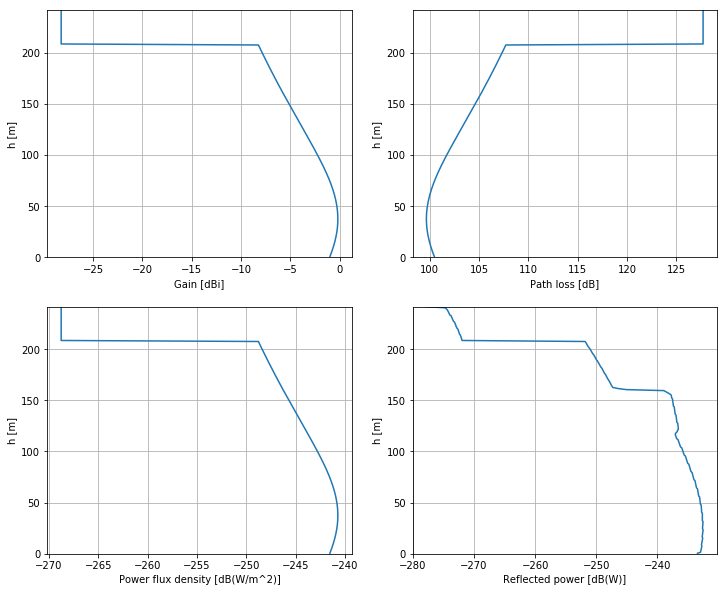

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].plot(result['gain'], result['height'])
axes[0, 1].plot(result['atten'], result['height'])
axes[1, 0].plot(result['power_flux'], result['height'])
axes[1, 1].plot(result['refl_power'], result['height'])
axes[0, 0].set_xlabel('Gain [dBi]')
axes[0, 1].set_xlabel('Path loss [dB]')
axes[1, 0].set_xlabel('Power flux density [dB(W/m^2)]')
axes[1, 1].set_xlabel('Reflected power [dB(W)]')
for ax in axes.flatten():
    ax.set_ylabel('h [m]')
    ax.set_ylim((0, result['height'][-1]))
    ax.grid()

In our example, the WT is so close, that the antenna pattern of the FL transmitter already plays a huge role!

### Step 3: Aggregated power at RT
Finally, one just needs to calculate the path propagation loss to the RT and sum-up the power from each height bin.

In [23]:
G_t = 0 * cnv.dBi
G_r = 0 * cnv.dBi

for idx in range(len(result)):
    
    h_wt = result['height'][idx] * u.m
    P_wt = result['refl_power'][idx]
    pprop_wt_rt = pathprof.PathProp(
        freq_ras,
        temperature, pressure,
        lon_wt, lat_wt,
        lon_rt, lat_rt,
        h_wt, h_rt,
        hprof_step,
        time_percent,
        zone_t=zone_t, zone_r=zone_r,
        )

    (
        L_bfsg, L_bd, L_bs, L_ba, L_b, L_b_corr, L
        ) = pathprof.loss_complete(pprop_wt_rt, G_t, G_r)

    result['power_rt'][idx] = P_wt - L.to_value(cnv.dB)

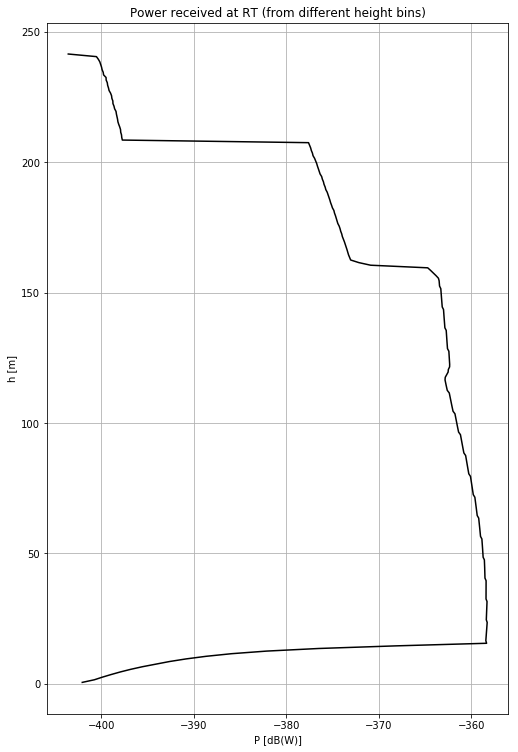

In [24]:
plt.close()
fig = plt.figure(figsize=(8, 12))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
ax.plot(result['power_rt'], result['height'], 'k-')
ax.set_xlabel('P [dB(W)]')
ax.set_ylabel('h [m]')
ax.grid()
ax.set_title('Power received at RT (from different height bins)')
plt.show()

In [25]:
P_rt_tot = np.sum(
    (result['power_rt'] * cnv.dB_W).to_value(u.W)
    ) * u.W
print('Total received power: {:.1f}'.format(P_rt_tot.to(cnv.dB_W)))

Total received power: -338.7 dB(W)


### Comparison with directly received power from FL Tx

One can compare this with the power received from the FL Tx on the direct path, -214 dB(W), derived in the [Fixed Link Notebook](A01_case_study_fixed_link.ipynb). Even over the very short distance between FL Tx and WT, there is already a huge propagation loss of about 100 dB! This impressively shows the huge impact of the $d^{-4}$ dependence in the RADAR equation.